## Policy Gradients - REINFORCE

References:
- https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-automating-pong-in-using-a-policy-model-an-implementation-b71f64c158ff
- https://github.com/keon/policy-gradient/blob/master/pg.py

Here we implement the REINFORCE policy gradient to play game "Pong" using OpenAI gym environment for <a href= https://gym.openai.com/envs/Pong-v0/>Pong </a>— a self-contained instance of the game that facilitates interfacing with the permissible actions within the game. To install the game, issue the following: 

`pip install gym[atari]`

Different from other experiments we have done so far, the states in this game is an image. We'll use convolutional neural networks to extract features from the state space and predict a good action. Although here we have discrete actions, certainly, you can also use REINFORCE algorithm for continuous actions, e.g. trading stocks. 

Now let's get start!

In [1]:
import gym
import numpy as np
import time
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D
import tensorflow.keras.backend as K
from tensorflow.keras import initializers
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from gym import wrappers

In [6]:
# Play the game 

env = gym.make("Pong-v0")
#env = wrappers.Monitor(env, video_callable=False ,force=True)
state = env.reset()


done = False
while not done:
    #env.render()
    action = np.random.choice(env.action_space.n)
    state, reward, done, info = env.step(action)

env.close()    # close the game

## Actions

There are six actions an agent (player) can take within the Pong environment, each assigned an integer, e.g.:

- remaining stationary (0), 
- vertical translation up (2), 
- vertical translation down (3)


In [7]:
env = gym.make("Pong-v0")
env.action_space

Discrete(6)

In [24]:
env.action_space.sample()

4

## States

Different from the previous examples, the states in this environment is an image, a three-dimensional array. However, note that this frame contains two many unnecessary details irrelevant to the actual gameplay itself: for example, the tracking of the rewards is done internally by the OpenAI gym environment. We’ll preprocess our frame by applying a crop and a grayscale, before flattening the output for a 1-dimensional neural network.

In [25]:
# preprocess to remove unnecessary details
def preprocess(I):
    I = I[35:195]
    I = I[::2, ::2, 0]
    I[I == 144] = 0
    I[I == 109] = 0
    I[I != 0] = 1
    return I.astype(np.float)

(210, 160, 3)


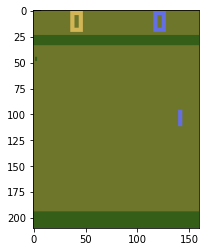

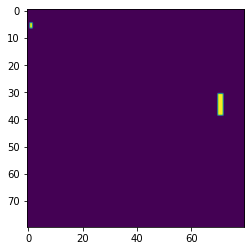

In [26]:
# if you get an error 
# install Atari by issuing: pip install gym[atari] 

state = env.reset()
#env.render()
print(state.shape)

# show original state
plt.imshow(state)
plt.show()

# show preprocessed state
plt.imshow(preprocess(state))

env.close()

In [27]:
preprocess(state).shape

(80, 80)

## Action neural network

With states identified, we start to define our action network. Naturally, we'll use convolutional neural network to process the input state and return the probability of each action. 

In [30]:
def _build_model(self):

    states = Input(shape = self.state_size + (1,) )  # input shape is (80, 80, 1)
    rewards = Input(shape = (1,))   # accumulated returns at each time, for calculating gradients

    conv = Conv2D(16, (3,3), padding='same', activation='relu')(states)
    pool = MaxPool2D((2,2))(conv)
    conv = Conv2D(64, (3,3), padding='same', activation='relu')(pool)
    pool = MaxPool2D((2,2))(conv)
    conv = Conv2D(32, (3,3), padding='same', activation='relu')(pool)
    flat = Flatten()(conv)
    h = Dense(256, activation='relu', init='he_uniform')(flat)
    output = Dense(self.action_size, activation='softmax') (h)

    model = Model(inputs = [states, rewards], outputs = output)

    opt = Adam(lr=self.learning_rate)

    policy_loss = self.policy_gradient_loss(rewards)

    model.compile(loss=policy_loss, optimizer=opt)

    return model

## Policy Gradients

Remember, the gradients for parameters $\theta$ in the action neural network at time $t$ is :

$$ \theta \rightarrow \theta + \alpha~\gamma^t~G~\nabla \ln \pi(A_t | S_t, \theta))$$       

Let's first calculate $$G = \sum_{k=t+1}^T {\gamma^{k-t-1}R_k}$$

Let $G_t$ denote the discounted reward received at time $t$. Suppose we have played an episode from ${0, 1, ..., T-1}$, we accumulate the rewards received at each step backwards, i.e.:
<br><br>
$$G_{T-1} = R_{T-1}$$ 
$$G_{T-2} = R_{T-2} + \gamma * G_{T-1} $$ 
...<br>
$$G_{0} = R_0 +\gamma * G_{1} $$

### Discounted Rewards

In [34]:
def discount_rewards(self, rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(0, rewards.size)):
        if rewards[t] != 0:   # For pong, a non-zero reward indicating the end of an episode, so the running reward is reset to 0
            running_add = 0   
        running_add = running_add * self.gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

### Calculate Gradients

In a neural network with parameters $\theta$, let's assume the following: 
1. it has prediction $\hat{y}$, 
2. the actual value is $y$, and 
3. the loss function is `categorical_cross_entropy`, 

Then the gradients can be written as $L = y~\nabla_{\theta}\ln\hat{y}$. If we multiply this loss by the `discounted reward` $\gamma^t~G$, i.e.  $L' = L * \gamma^t~G$, then we'll have the exact gradient formula used in REINFORCE algorithm. Moreover, we normalize $\gamma^t~G$ so that the training can converge fast.

Let's make our neural network to have an additional input for `discounted reward`. Then we create a custom loss function. Note that a custom loss function always only takes two inputs: ground truth $y$ and predicted $\hat{y}$. However, we need to pass the additional parameter, `discounted reward`. To achieve this, we play a trick to define a function which has the `discounted reward` as the input parameter, and returns the a loss function with ground truth $y$ and predicted $\hat{y}$. The `discounted reward` as a global variable now can be passed to the loss function. The code can be found below.

In [ ]:
def policy_gradient_loss(self, Returns):
    def modified_crossentropy(action,action_probs):
        cost = K.categorical_crossentropy(action, action_probs,\
                                          from_logits=False, axis=1)
        g = K.squeeze(Returns, axis = -1)
        cost = cost * g
        return K.mean(cost)
    return modified_crossentropy

### Train model

The neural network is trained as usual. Note that there are two inputs: One is the stack of history states in an episode, and the other is the discounted rewards. The output is the actual actions taken in the episode. The actions are sampled by the probabilities output by the network

In [ ]:
def train(self):
    rewards = np.vstack(self.rewards)
    rewards = self.discount_rewards(rewards)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7) # normalization

    # reshape states to [Batch, 80, 80, 1]
    X = np.stack(self.states, axis = 0)
    X = np.expand_dims(X, axis = -1) 

    Y = np.vstack(self.actions)

    self.model.train_on_batch([X, rewards], Y)

    self.states, self.probs, self.actions, self.rewards = [], [], [], []

In [4]:
state_test = np.vstack(np.array([1,2,3,4,5]))

In [5]:
np.stack(state_test, axis = 0)

array([[1],
       [2],
       [3],
       [4],
       [5]])

## Put everything together

You can play the game very well after training for 500 episodes. You can also load the trained model

In [2]:
def preprocess(I):
    I = I[35:195]
    I = I[::2, ::2, 0]
    I[I == 144] = 0
    I[I == 109] = 0
    I[I != 0] = 1
    return I.astype(np.float)

In [3]:
class PGAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99
        self.learning_rate = 0.001
        self.states = []
        self.actions = []
        #self.gradients = []
        self.rewards = []
        self.probs = []
        self.model = self._build_model()
        self.model.summary()
        
        
    def policy_gradient_loss(self, Returns):
        def modified_crossentropy(action,action_probs):
            cost = K.categorical_crossentropy(action, action_probs,\
                                              from_logits=False, axis=1)
            g = K.squeeze(Returns, axis = -1)
            cost = cost * g
            return K.mean(cost)
        return modified_crossentropy

    def _build_model(self):
        
        states = Input(shape = self.state_size + (1,) )  # input shape is (80, 80, 1)
        rewards = Input(shape = (1,))   # accumulated returns at each time
        
        conv = Conv2D(16, (3,3), padding='same', activation='relu')(states)
        pool = MaxPool2D((2,2))(conv)
        conv = Conv2D(64, (3,3), padding='same', activation='relu')(pool)
        pool = MaxPool2D((2,2))(conv)
        conv = Conv2D(32, (3,3), padding='same', activation='relu')(pool)
        flat = Flatten()(conv)
        # h = Dense(256, activation='relu', init='he_uniform')(flat)
        h = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform())(flat)
        output = Dense(self.action_size, activation='softmax') (h)
        
        model = Model(inputs = [states, rewards], outputs = output)
        
        opt = Adam(lr=self.learning_rate)
        
        policy_loss = self.policy_gradient_loss(rewards)
        
        model.compile(loss=policy_loss, optimizer=opt)
        
        return model

    def memorize(self, state, action, prob, reward):
        y = np.zeros([self.action_size])
        y[action] = 1
        #self.gradients.append(np.array(y).astype('float32') - prob)
        self.actions.append(y)
        self.states.append(state)
        self.rewards.append(reward)

    def act(self, state):
        state = np.expand_dims(state, axis = -1) # rehape to (80, 80, 1)
        state = np.expand_dims(state, axis = 0) # rehape to (1, 80, 80, 1)
        prob = self.model.predict([state, np.zeros((1,1))]).flatten() # need change
        self.probs.append(prob)
        #prob = aprob / np.sum(aprob)
        action = np.random.choice(self.action_size, 1, p=prob)[0]
        return action, prob

    def discount_rewards(self, rewards):# undiscounted for our case
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, rewards.size)):
            if rewards[t] != 0:
                running_add = 0
            running_add = running_add * self.gamma + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards
    

    def train(self): # need change
        rewards = np.vstack(self.rewards)
        rewards = self.discount_rewards(rewards)
        rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
        
        # reshape states to [Batch, 80, 80, 1]
        X = np.stack(self.states, axis = 0)
        X = np.expand_dims(X, axis = -1) 
        
        Y = np.vstack(self.actions)
        
        self.model.train_on_batch([X, rewards], Y)
        
        self.states, self.probs, self.actions, self.rewards = [], [], [], []

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)



In [4]:
env = gym.make("Pong-v0")
state = env.reset()
prev_x = None
score = 0
episode = 0
total_episodes = 10000

state_size = (80, 80)
action_size = env.action_space.n
agent = PGAgent(state_size, action_size)
steps = 0

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 40, 64)   9280        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [ ]:
if __name__ == "__main__":
    env = gym.make("Pong-v0")
    state = env.reset()
    prev_x = None
    score = 0
    episode = 0
    total_episodes = 10000

    state_size = (80, 80)
    action_size = env.action_space.n
    agent = PGAgent(state_size, action_size)
    steps = 0
    agent.load('pong.h5')
    while episode < total_episodes:
        # env.render()
        start_time = time.time()
        
        cur_x = preprocess(state)
        x = cur_x - prev_x if prev_x is not None else np.zeros(state_size)
        
        prev_x = cur_x
        #print(cur_x.shape)

        action, prob = agent.act(x)
        state, reward, done, info = env.step(action)
        #print(reward)
        score += reward
        
        agent.memorize(x, action, prob, reward)
        steps += 1
        if done:
            
            episode += 1
            agent.train()
            print('Episode: %d - Score: %.2f - steps %d - time: %.2f' % (episode, score, steps, time.time()-start_time))
            score = 0
            state = env.reset()
            prev_x = None
            steps = 0
            if episode > 1 and episode % 10 == 0:
                agent.save('pong.h5')
    
    env.close()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 40, 64)   9280        max_pooling2d[0][0]              
_______________________________________________________________________________________

C:\Users\cheng\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Episode: 1 - Score: -20.00 - steps 1243 - time: 2.12
Episode: 2 - Score: -21.00 - steps 1214 - time: 1.98
Episode: 3 - Score: -20.00 - steps 1351 - time: 2.22
Episode: 4 - Score: -19.00 - steps 1355 - time: 2.43
Episode: 5 - Score: -19.00 - steps 1431 - time: 2.45
Episode: 6 - Score: -21.00 - steps 1192 - time: 2.06
Episode: 7 - Score: -20.00 - steps 1117 - time: 1.94
Episode: 8 - Score: -20.00 - steps 1224 - time: 2.29
Episode: 9 - Score: -20.00 - steps 1290 - time: 3.14
Episode: 10 - Score: -18.00 - steps 1440 - time: 3.42
Episode: 11 - Score: -21.00 - steps 1098 - time: 2.35
Episode: 12 - Score: -19.00 - steps 1332 - time: 2.35
Episode: 13 - Score: -21.00 - steps 1097 - time: 1.91
Episode: 14 - Score: -20.00 - steps 1126 - time: 1.97
Episode: 15 - Score: -20.00 - steps 1233 - time: 2.15


## Next step (Optional Assignment)

- Change the code to implement algorithms Actor-Critic and A2C (Advantage Actor-Critic). A good reference can be found at https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
- Compare the performance of these three algorithms to which one converges better.

In [6]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
